In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = f"../select_db/data_mapping_filtered.csv"
# data_path = f"../test_data/data_mapping_filtered.csv"
# Ensure to include 'ships_idx' in the fields list
fields = ['ships_idx', 'tag_name', 'tag_description', 'thing', 'property']

# Load the dataset
try:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)
except UnicodeDecodeError:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields, encoding='ISO-8859-1')



## Problem: sample by ships_idx alone might not lead to correct distribution of data

splitting by ship_idx alone might not lead to fair distribution of observation count since ship_idx do not share uniform counts. 

The solution is just to randomly sample ship_idx until the row_counts hit the desired target count

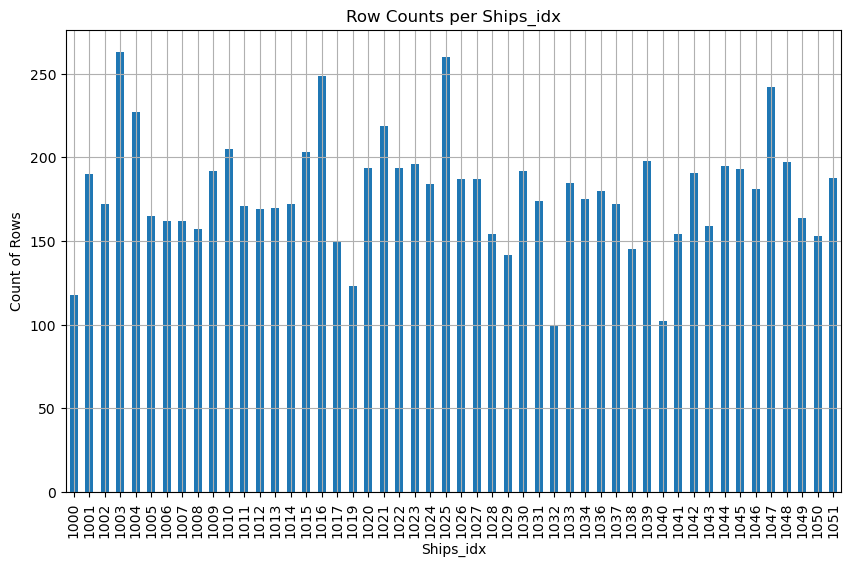

In [2]:
# Group the data by 'ships_idx' and count the rows for each group
row_counts = df.groupby('ships_idx').size()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
row_counts.plot(kind='bar')  # You can also use 'barh' for a horizontal bar plot
plt.title('Row Counts per Ships_idx')
plt.xlabel('Ships_idx')
plt.ylabel('Count of Rows')
plt.grid(True)
plt.show()


In [3]:
import random


# function purpose: randomly sample until total counts hit the required proportion
# argument 1: dictionary of ship_idx to count
# argument 2: target proportion of total counts in argument 1
# argument 3: seed for random generator
def sample_idx_until_proportion(count_by_ship_idx, target_proportion, seed):

    random.seed(seed)
    ship_idx_list = list(count_by_ship_idx.keys())

    total_count = sum(count_by_ship_idx.values())
    target_count = int(total_count * target_proportion)

    selected_ships = []
    total_selected_counts = 0

    # sample ship_idx until counts are close enough to target
    # add a buffer of 100 to stop once close enough
    while (total_selected_counts < target_count - 100): 
        
        # Select a ship using random sampling without replacement
        chosen_ship_idx = random.choice(ship_idx_list)
        counts = count_by_ship_idx[chosen_ship_idx]
        
        # Add the chosen ship to the selected ship list
        selected_ships.append(chosen_ship_idx)
        total_selected_counts += counts

        # remove selected ship from sampling list
        ship_idx_list.remove(chosen_ship_idx)
    return selected_ships, total_selected_counts
    

In [4]:
seed = 43
count_by_ship_idx = df.groupby('ships_idx').size().to_dict()

total_ship_idx_set = set(count_by_ship_idx.keys())
# sample idx's for training data
training_ship_idx_selection, training_counts = sample_idx_until_proportion(count_by_ship_idx, 0.8, seed=seed)
val_test_ship_idx_set = total_ship_idx_set - set(training_ship_idx_selection)
# sample idx's for validation data
count_by_ship_idx_val_test_set = { ship_idx: count_by_ship_idx[ship_idx] for ship_idx in list(val_test_ship_idx_set) }
# note that 0.5 is for the ship_idx set that remains after removing training ship_idx's
val_ship_idx_selection, validation_counts = sample_idx_until_proportion(count_by_ship_idx_val_test_set, 0.5, seed=seed)
# sample idx's for test data
test_ship_idx_selection = val_test_ship_idx_set - set(val_ship_idx_selection)

# get report of split
total_counts = sum(count_by_ship_idx.values())
print("training proportion: ", training_counts/total_counts)
print("validation proportion: ", validation_counts/total_counts)
print("test proportion: ", (total_counts - training_counts - validation_counts)/total_counts)


print("training ship idx selection:")
print(training_ship_idx_selection)

print("validation ship idx selection:")
print(val_ship_idx_selection)

print("training ship idx selection:")
print(test_ship_idx_selection)

train_idx = training_ship_idx_selection
test_idx = test_ship_idx_selection
validation_idx = val_ship_idx_selection

training proportion:  0.7979280383201515
validation proportion:  0.09256990085774758
test proportion:  0.10950206082210093
training ship idx selection:
[1002, 1020, 1048, 1010, 1033, 1027, 1050, 1007, 1037, 1047, 1040, 1051, 1001, 1043, 1036, 1030, 1039, 1034, 1015, 1003, 1045, 1006, 1046, 1008, 1022, 1011, 1009, 1014, 1032, 1031, 1013, 1028, 1044, 1023, 1017, 1021, 1004, 1000, 1041, 1005]
validation ship idx selection:
[1024, 1042, 1029, 1012, 1038]
training ship idx selection:
{1025, 1026, 1016, 1049, 1019}


## Understanding huggingface datasets

Each dataframe row must be reorganized into the format of 'translation: {input: "data1", output: "data2"}'. This is due to a quirk in the way datasets are enumerated in `t5_train_tp.py/ipynb`.

Hence it is easier to just create a list of dictionaries, where each dictionary is 1 corresponding dataframe row, and then create a dataset by using `Dataset.from_list` on the list of dictionaries.

3 separate datasets are assigned a key and combined into a DatasetDict for each of the 'train', 'test', 'validation' splits.

Individual datasets can be saved as csv, json text-files, but DatasetDict can only be saved via `save_to_disk`. 

The decision to save a DatasetDict rather than 3 separate Datasets means that subsequent training and inference data imports are made much simpler without the need to re-create the dictionary structure.

The downside is that the folder is slightly less portable, but the folder is still relatively space-efficient compared to saving in the original json file format due to the use of PyArrow internal structures.



In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Filter the DataFrame based on the split indices
train_df = df[df['ships_idx'].isin(train_idx)]
test_df = df[df['ships_idx'].isin(test_idx)]
validation_df = df[df['ships_idx'].isin(validation_idx)]

# convert each dataframe row into a dictionary
# outputs a list of dictionaries
def process_df(df):
    output_list = []
    for idx, row in df.iterrows():
        try:
            output_list.append({
                'translation': {
                    'ships_idx': row['ships_idx'],
                    'tag_description': str(row['tag_description']),
                    'thing_property': f"<THING_START>{str(row['thing'])}<THING_END><PROPERTY_START>{str(row['property'])}<PROPERTY_END>",
                    'answer': f"{str(row['thing'])} {str(row['property'])}",
                }
            })
        except Exception as e:
            print(f"Error processing row at index {idx}: {row}")
            print(f"Exception: {e}")
    return output_list

try:
    combined_data = DatasetDict({
        'train': Dataset.from_list(process_df(train_df)),
        'test': Dataset.from_list(process_df(test_df)),
        'validation': Dataset.from_list(process_df(validation_df)),
    })

    combined_data.save_to_disk("combined_data")
except Exception as e:
    print(f"Error creating DatasetDict: {e}")


Saving the dataset (0/1 shards):   0%|          | 0/7163 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/983 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/831 [00:00<?, ? examples/s]